In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import os
import os.path
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import wandb
import soundfile as sf

In [2]:
import numpy as np
import librosa
import os

audio_files = "./lexscrapesegmented/"
audio_files_list = [audio_files+x for x in os.listdir(audio_files)]
sr = 4096

def update_running_stats(mean, M2, count, new_values):
    count += len(new_values)
    delta = new_values - mean
    mean += delta.sum() / count
    delta2 = new_values - mean
    M2 += (delta * delta2).sum()
    return mean, M2, count

def finalize_stats(mean, M2, count):
    variance = M2 / count
    std = np.sqrt(variance)
    return mean, std

def compute_global_stats(audio_files, n_mels=80, win_length_ms=25, hop_length_ms=10, sample_rate=16000):
    mean = 0.0
    M2 = 0.0
    count = 0

    for idx, file in enumerate(audio_files):
        if idx%10:
            print(idx/len(audio_files))
        y = np.load(file)
        win_length = int(win_length_ms * sr / 1000)
        hop_length = int(hop_length_ms * sr / 1000)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, 
                                                         n_fft=win_length, 
                                                         hop_length=hop_length, 
                                                         win_length=win_length)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        flattened_spectrogram = log_mel_spectrogram.flatten()

        mean, M2, count = update_running_stats(mean, M2, count, flattened_spectrogram)
        

    mean, std = finalize_stats(mean, M2, count)
    return mean, std

def normalize_spectrogram(spectrogram, mean, std):
    return (spectrogram - mean) / std

# Compute global stats (to be done once on the training dataset)
mean, std = compute_global_stats(audio_files_list)

# Save these parameters for inference
np.save('mean.npy', mean)
np.save('std.npy', std)

'''
# During training, normalize each spectrogram
def preprocess_audio(audio_path, mean, std, n_mels=80, win_length_ms=25, hop_length_ms=10, sample_rate=16000):
    y, sr = librosa.load(audio_path, sr=sample_rate)
    win_length = int(win_length_ms * sr / 1000)
    hop_length = int(hop_length_ms * sr / 1000)
    mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, 
                                                     n_fft=win_length, 
                                                     hop_length=hop_length, 
                                                     win_length=win_length)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    normalized_log_mel_spectrogram = normalize_spectrogram(log_mel_spectrogram, mean, std)
    return normalized_log_mel_spectrogram

# Load the pre-computed mean and std for inference
mean = np.load('mean.npy')
std = np.load('std.npy')

# Example usage during inference
audio_path = 'test_audio.wav'  # Replace with your audio file path
normalized_log_mel_spectrogram = preprocess_audio(audio_path, mean, std)

print("Normalized Log-Magnitude Mel Spectrogram Shape:", normalized_log_mel_spectrogram.shape)
'''


4.855311711011847e-05
9.710623422023694e-05
0.0001456593513303554
0.0001942124684404739
0.00024276558555059235
0.0002913187026607108
0.0003398718197708293
0.0003884249368809478
0.0004369780539910662
0.0005340842882113031
0.0005826374053214216
0.0006311905224315401
0.0006797436395416586
0.0007282967566517771
0.0007768498737618955
0.000825402990872014
0.0008739561079821324
0.0009225092250922509
0.0010196154593124878
0.0010681685764226062
0.0011167216935327247
0.0011652748106428432
0.0012138279277529617
0.0012623810448630802
0.0013109341619731987
0.0013594872790833172
0.0014080403961934356
0.0015051466304136726
0.001553699747523791
0.0016022528646339096
0.001650805981744028
0.0016993590988541463
0.0017479122159642648
0.0017964653330743833
0.0018450184501845018
0.0018935715672946203
0.0019906778015148572
0.0020392309186249755
0.0020877840357350942
0.0021363371528452125
0.002184890269955331
0.0022334433870654495
0.002281996504175568
0.0023305496212856864
0.002379102738395805
0.0024762089726

'\n# During training, normalize each spectrogram\ndef preprocess_audio(audio_path, mean, std, n_mels=80, win_length_ms=25, hop_length_ms=10, sample_rate=16000):\n    y, sr = librosa.load(audio_path, sr=sample_rate)\n    win_length = int(win_length_ms * sr / 1000)\n    hop_length = int(hop_length_ms * sr / 1000)\n    mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, \n                                                     n_fft=win_length, \n                                                     hop_length=hop_length, \n                                                     win_length=win_length)\n    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)\n    normalized_log_mel_spectrogram = normalize_spectrogram(log_mel_spectrogram, mean, std)\n    return normalized_log_mel_spectrogram\n\n# Load the pre-computed mean and std for inference\nmean = np.load(\'mean.npy\')\nstd = np.load(\'std.npy\')\n\n# Example usage during inference\naudio_path = \'test

In [ ]:
n_mels
m = np.memmap('train.bin', dtype=np.float32, mode='r', shape=(total_frames, n_mels))

In [2]:
import numpy as np

def calculate_num_frames(audio_length_seconds, sr=8000, win_length_ms=25, hop_length_ms=10):
    win_length = sr * win_length_ms / 1000  # window length in samples
    hop_length = sr * hop_length_ms / 1000  # hop length in samples
    num_samples = sr * audio_length_seconds  # number of samples in the audio
    num_frames = np.ceil((num_samples - win_length) / hop_length).astype(int) + 1
    return num_frames

# Example usage:
audio_length_seconds = 16
num_frames = calculate_num_frames(audio_length_seconds)
print(num_frames)  # Output: 99 frames

1599


In [7]:
mean = np.load('mean.npy')
std = np.load('std.npy')
print(mean, std)
def preprocess_audio(audio_path, mean, std, n_mels=80, win_length_ms=25, hop_length_ms=10, sample_rate=8000):
    y, sr = librosa.load(audio_path, sr=sample_rate)
    y = y[0:8000*16]
    win_length = int(win_length_ms * sr / 1000)
    hop_length = int(hop_length_ms * sr / 1000)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, 
                                                     n_fft=win_length, 
                                                     hop_length=hop_length, 
                                                     win_length=win_length)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

print(np.shape(preprocess_audio("./nanoGPT-master/data/lexaudio/lexscrape/Aaron Smith-Levin： Scientology ｜ Lex Fridman Podcast #361.mp3", mean, std)))

-52.269829176790296 19.784260009230795
(80, 1601)


In [4]:
'''
wandb.init(
    # set the wandb project where this run will be logged
    project="audiotransformerexperimentlex",
)'''

save_file_name = "audiofirsttry.pt"
audio_files = "./lexscrapesegmented/"
audio_file_list = [audio_files+x for x in os.listdir(audio_files)]

audio_mean = np.load('mean.npy')
audio_std = np.load('std.npy')
# hyperparameters
batch_size = 128 # how many independent sequences will we process in parallel?
block_size = 16 # what is the maximum context length in seconds for predictions?
max_iters = 50000
eval_interval = 250
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
sr = 4096
n_embd = 512
n_head = 8
n_layer = 8
dropout = 0.2
n_mels = 80
# ------------

torch.manual_seed(1337)

class AudioDataset(Dataset):
    def __init__(self, file_list):
        self.file_list = file_list
        self.sr = sr
        self.segment_length = block_size
        self.segment_samples = int((self.segment_length+1) * self.sr) # Plus one for the targes array

    def __len__(self):
        return len(self.file_list)

    def preprocess_audio(y, mean, std, n_mels=80, win_length_ms=25, hop_length_ms=10):
        win_length = int(win_length_ms * sr / 1000)
        hop_length = int(hop_length_ms * sr / 1000)
        mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_mels=n_mels, 
                                                        n_fft=win_length, 
                                                        hop_length=hop_length, 
                                                        win_length=win_length)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        normalized_log_mel_spectrogram = normalize_spectrogram(log_mel_spectrogram, mean, std)
        return normalized_log_mel_spectrogram

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        audio = np.load(file_path)

        # Ensure audio is at least as long as the segment length
        if len(audio) < self.segment_samples:
            padding = self.segment_samples - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')

        # Randomly select a segment from the audio file
        start_idx = np.random.randint(0, len(audio) - self.segment_samples + 1)
        end_idx = start_idx + self.segment_samples-self.sr # -1s for the included targets length
        audio_segment = audio[start_idx:end_idx]
        audio_targets = audio[start_idx+self.sr:end_idx+self.sr]
        mel_spec = self.preprocess_audio(audio_segment, audio_mean, audio_std, sample_rate=sr)
        mel_spec_targets = self.preprocess_audio(audio_targets, audio_mean, audio_std, sample_rate=sr)
        return torch.tensor(mel_spec), torch.tensor(mel_spec_targets)

def create_dataloader(file_list):
    dataset = AudioDataset(file_list)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    return dataloader

n = int(0.9*len(audio_file_list)) # first 90% will be train, rest val
train_files = audio_file_list[:n]
val_files = audio_file_list[n:]
train_dataloader = create_dataloader(train_files)
val_dataloader = create_dataloader(val_files)
#batch = next(iter(train_dataloader))

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    dataloader = train_dataloader if split == 'train' else val_dataloader
    x, y = next(iter(dataloader))
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Conv1d(nn.Conv1d):
    def _conv_forward(self, x, weight, bias):
        return super()._conv_forward(x, weight.to(x.dtype), None if bias is None else bias.to(x.dtype))

def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        #self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.conv1 = Conv1d(n_mels, n_embd, kernel_size=3, padding=1)
        self.conv2 = Conv1d(n_embd, n_embd, kernel_size=3, stride=2, padding=1)
        self.register_buffer("positional_embedding", sinusoids(block_size, n_embd))
        #self.seq_to_channel_proj = nn.Linear(sr*block_size, n_embd)
        #self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, sr)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        """
        x : torch.Tensor, shape = (batch_size, n_mels, n_ctx)
            the mel spectrogram of the audio
        """
        print(idx.shape)
        B, T = idx.shape
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = x.permute(0, 2, 1)

        assert x.shape[1:] == self.positional_embedding.shape, "incorrect audio shape"
        x = (x + self.positional_embedding).to(x.dtype)

        # idx and targets are both (B,T) tensor of integers
        x = idx.view(B, T // (sr*block_size), sr*block_size) # (B,T,full sequence len)
        x = self.seq_to_channel_proj(x) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T//(sr*block_size), device=device)) # (T,C)
        x = x + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,next "token" or sr samples)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T*sr)
            targets = targets.view(B*T*sr)
            loss = F.mse_loss(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -(block_size*sr):]
            print("idx_cond", idx_cond.shape)
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            #logits = logits[:, -1, :] # becomes (B, C)
            # append sampled index to the running sequence
            idx = torch.cat((idx, logits[:,-1]), dim=1) # (B, T+1)
        return idx

# if we have a pt file for model load it if not blank instantiation
model = None
'''
if os.path.isfile(save_file_name):
  model = torch.load(save_file_name)
  print(f"loaded from {save_file_name}")
else:
  model = GPTLanguageModel()
'''
model = GPTLanguageModel()

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iteration in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iteration % eval_interval == 0 or iteration == max_iters - 1:
        torch.save(model, save_file_name)
        losses = estimate_loss()
        print(f"step {iteration}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        #wandb.log({"iter": iteration, "train loss": losses['train'], "val loss": losses['val']})
        context, targets = next(iter(train_dataloader))
        context = context.to(device)
        print("context", context.shape)
        output = m.generate(context[0].unsqueeze(0), max_new_tokens=block_size)
        print("output", output.shape)
        sf.write('tmp.wav', output[0].tolist(), sr, 'PCM_24')
        break

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
Audio(data=m.generate(context, max_new_tokens=block_size*2)[0].tolist(), rate=sr)


92.390912 M parameters
step 0: train loss 0.2156, val loss 0.2158
context torch.Size([128, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
idx_cond torch.Size([1, 65536])
output torch.Size([1, 1114112])
idx_cond torch.Size([1, 1])


RuntimeError: shape '[1, 0, 65536]' is invalid for input of size 1

In [12]:
output = next(iter(train_dataloader))
sf.write('tmp.wav', output[0][0], sr, 'PCM_24')
Audio(data=output[0][0], rate=sr)


In [ ]:
save_file_name = "audiofirsttry.pt"
model = torch.load(save_file_name)
print(f"loaded from {save_file_name}")


m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=sr*block_size)[0].tolist()))

In [11]:
torch.save(model, save_file_name)
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=sr*block_size)[0].tolist()))

	. Rötley cruised Stanley as Mrsjoy during taxonomy, in several every experience in Low Visibulary Locals (Tamil Army).

Evolution
  Mr. Didney, his composition article assassination overIndian may be a slegible.

Sanganella graves 

In the June

There is an architect with CB skin Planta knibt Spain. Unlike clears sleevery fathering on the bonknown East Antarcts Norway to Air? 3 in London, said that with Cornwalt Therzos Bridgan uple.

The city of Kubatl is worshipped in a country mountainst of Bayer for audio rai. No matter honor Oschway is divined into denser Beglard: Paul Guballr Fulstron (British Bobbyl) Paul Paul is symbolated by Istims of today, Spain. Since of the Bob Ford, become the mission of Mount of Judaism. June 10 – Fulstrong defeats a Mosco nova in November and sentral his death claiming that is a national parish part of Asia to parent.
Paul Paul Pari entreated members at onboard Mutube: journaled South War develops that Kogai goes it did not want to be at the legant.

U

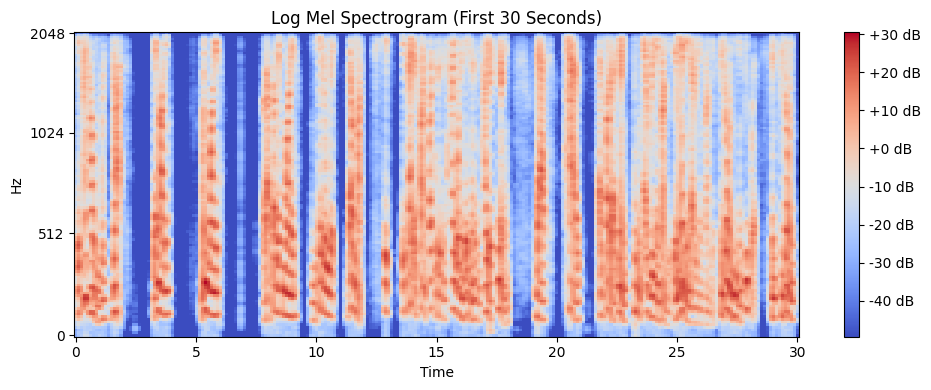

In [45]:

# Load the MP3 file
y, sr = librosa.load('./lexscrape2/Aaron Smith-Levin： Scientology ｜ Lex Fridman Podcast #361.mp3', sr=4096)

# Define the duration you want to extract (in seconds)
duration = 30  # 30 seconds

# Calculate the number of samples corresponding to the duration
num_samples = int(duration * sr)

# Slice the audio signal to include only the first `num_samples` samples
y_short = y[:num_samples]

# Extract the mel spectrogram for the sliced audio
mel_spectrogram = librosa.feature.melspectrogram(y=y_short, sr=sr)

# Convert to decibels (log scale)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

# Display the log mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log Mel Spectrogram (First 30 Seconds)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [24]:
for i in range(44):
    y = np.load(f"./lexscrapesegmented/Aaron Smith-Levin： Scientology ｜ Lex Fridman Podcast #361-{i}.npy")
Audio(data=y, rate=4096)

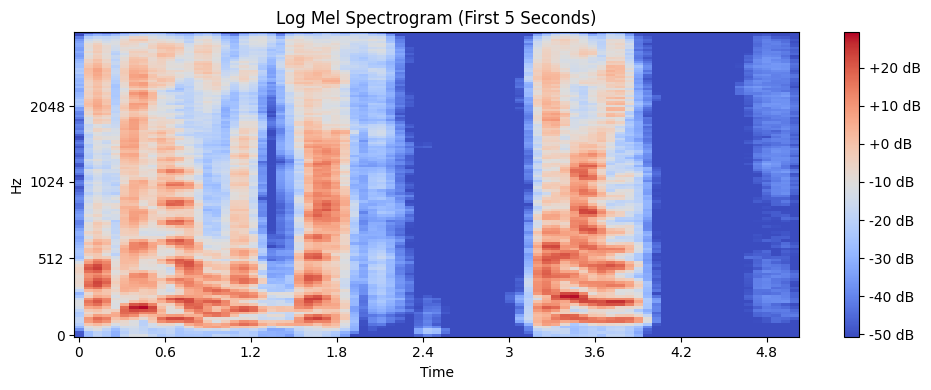

In [6]:
# Define the duration you want to extract (in seconds)
duration = 5  # 30 seconds

# Calculate the number of samples corresponding to the duration
num_samples = int(duration * sr)

# Slice the audio signal to include only the first `num_samples` samples
y_short = y[:num_samples]

# Extract the mel spectrogram for the sliced audio
mel_spectrogram = librosa.feature.melspectrogram(y=y_short, sr=sr)

# Convert to decibels (log scale)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

# Display the log mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.title('Log Mel Spectrogram (First 5 Seconds)')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [17]:
import os
import numpy as np
import librosa

audio_files = "./lexscrape2/"
audio_file_list = [audio_files+x for x in os.listdir(audio_files)]
output_directory = "./lexscrapesegmented"
if not os.path.exists(output_dir):
    os.makedirs(output_directory)


# Load audio file using librosa
for file_idx, file in enumerate(audio_file_list):
    print(file_idx/len(audio_files))
    y, sr = librosa.load(file, sr=4096)
    audio_chunk_size = sr*60*3 # 3 min chunks
    for idx, i in enumerate(range(0, len(y), audio_chunk_size)):
        # Save the array to an npy file
        tmp = y[i:i+audio_chunk_size]
        output_dir = f'{output_directory}/{file.split("/")[2][:-4]}-{idx}.npy'
        np.save(output_dir, tmp)

0.0
0.07692307692307693
0.15384615384615385
0.23076923076923078
0.3076923076923077
0.38461538461538464
0.46153846153846156
0.5384615384615384
0.6153846153846154
0.6923076923076923
0.7692307692307693
0.8461538461538461
0.9230769230769231
1.0
1.0769230769230769
1.1538461538461537
1.2307692307692308
1.3076923076923077
1.3846153846153846
1.4615384615384615
1.5384615384615385
1.6153846153846154
1.6923076923076923
1.7692307692307692
1.8461538461538463
1.9230769230769231
2.0
2.076923076923077
2.1538461538461537
2.230769230769231
2.3076923076923075
2.3846153846153846
2.4615384615384617
2.5384615384615383
2.6153846153846154
2.6923076923076925
2.769230769230769
2.8461538461538463
2.923076923076923
3.0
3.076923076923077
3.1538461538461537
3.230769230769231
3.3076923076923075
3.3846153846153846
3.4615384615384617
3.5384615384615383
3.6153846153846154
3.6923076923076925
3.769230769230769
3.8461538461538463
3.923076923076923
4.0
4.076923076923077
4.153846153846154
4.230769230769231
4.307692307692307